
# Prerequisiti: File Api kaggle
# Opzionale: Immagini per test

In [2]:
!pip install opencv-python
!pip install matplotlib
!pip install tensorflow
!pip install kaggle
!pip install seaborn
!pip install matplotlib
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.3 MB/s eta 0:00:00


In [3]:
!kaggle datasets download -d msambare/fer2013

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
from google.colab import files

# Carica il file kaggle.json scaricato
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robertobiggi","key":"65a3315c2ead7638b2d4948fececb386"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d msambare/fer2013

 93% 56.0M/60.3M [00:00<00:00, 75.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 90.3MB/s]


In [7]:
!unzip fer2013.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating:

In [8]:
import tensorflow as tf
import cv2
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from keras import regularizers

## Analisi e normalizzazione dati

In [9]:
# Definisci il nome di ciascuna classe (nomi delle cartelle delle immagini)
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']

# Stampa il numero di immagini per ogni classe
folder_path = "/content"
print("train:")
for cls in classes:
    path = os.path.join(folder_path, 'train', cls)
    lst = os.listdir(path)
    number_files = len(lst)
    print(cls, ': ', number_files)
print("")
print("test:")
for cls in classes:
    path = os.path.join(folder_path, 'test', cls)
    lst = os.listdir(path)
    number_files = len(lst)
    print(cls, ': ', number_files)

train:
angry :  3995
disgust :  436
fear :  4097
happy :  7215
neutral :  4965
sad :  4830
surprise :  3171

test:
angry :  958
disgust :  111
fear :  1024
happy :  1774
neutral :  1233
sad :  1247
surprise :  831


In [10]:
# Funzione per leggere tutte le immagini: ridimensionarle e convertirle in array usando OpenCV

img_size = 48
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join(folder_path, 'train', category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

# Aggiunta per far funzionare il codice
create_training_data()

In [11]:
# Funzione per leggere tutte le immagini: ridimensionarle e convertirle in array usando OpenCV

img_size = 48
test_data = []

def create_test_data():
    for category in classes:
        path = os.path.join(folder_path, 'test', category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                test_data.append([new_array, class_num])
            except Exception as e:
                pass

# Aggiunta per far funzionare il codice
create_test_data()

# Modello

In [1]:
train_dir="train"
test_dir="test"

train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",              # Converts the images to rgb
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

test_generator = test_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",              # Converts the images to rgb
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

NameError: ignored

In [13]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [14]:
# Funzione di callback per salvare il modello migliore
class SaveBestModel(Callback):

    def __init__(self, save_best_metric, best_model_name):
        super(SaveBestModel, self).__init__()
        self.save_best_metric = save_best_metric
        self.best_model_name = best_model_name
        self.best_value = float('-inf') if 'acc' in save_best_metric else float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.save_best_metric)
        if current_value is None:
            return

        if ('acc' in self.save_best_metric and current_value > self.best_value) or \
           ('loss' in self.save_best_metric and current_value < self.best_value):
            self.best_value = current_value
            self.model.save(self.best_model_name)
            print(f"\nSaved model with {self.save_best_metric}: {current_value}")

In [15]:
# Salva il miglior modello utilizzando il callback personalizzato
checkpoint = SaveBestModel(save_best_metric='val_accuracy', best_model_name='best_model.h5')

# Addestra il modello
history = model.fit(x = train_generator,epochs = 60, validation_data = test_generator, callbacks=[checkpoint])

Epoch 1/60
359/359 [==============================] - ETA: 0s - loss: 9.2487 - accuracy: 0.1927
Saved model with val_accuracy: 0.19134078919887543
359/359 [==============================] - 41s 68ms/step - loss: 9.2487 - accuracy: 0.1927 - val_loss: 8.4373 - val_accuracy: 0.1913


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/60
359/359 [==============================] - ETA: 0s - loss: 8.1393 - accuracy: 0.2251
Saved model with val_accuracy: 0.27723464369773865
359/359 [==============================] - 23s 64ms/step - loss: 8.1393 - accuracy: 0.2251 - val_loss: 7.4148 - val_accuracy: 0.2772
Epoch 3/60
359/359 [==============================] - ETA: 0s - loss: 7.0408 - accuracy: 0.2496
Saved model with val_accuracy: 0.291201114654541
359/359 [==============================] - 26s 73ms/step - loss: 7.0408 - accuracy: 0.2496 - val_loss: 6.3503 - val_accuracy: 0.2912
Epoch 4/60
359/359 [==============================] - ETA: 0s - loss: 6.0300 - accuracy: 0.2721
Saved model with val_accuracy: 0.31564244627952576
359/359 [==============================] - 24s 67ms/step - loss: 6.0300 - accuracy: 0.2721 - val_loss: 5.4273 - val_accuracy: 0.3156
Epoch 5/60
359/359 [==============================] - ETA: 0s - loss: 5.1057 - accuracy: 0.3046
Saved model with val_accuracy: 0.330307275056839
359/359 [========

In [16]:
# Carica il miglior modello salvato
best_model = tf.keras.models.load_model('best_model.h5')

# Valuta il modello
test_loss, test_acc = best_model.evaluate(test_generator, verbose=2)
print(f'\nAccuracy sul test: {test_acc}')

23/23 - 1s - loss: 1.3535 - accuracy: 0.6823 - 771ms/epoch - 34ms/step

Accuracy sul test: 0.6822625994682312


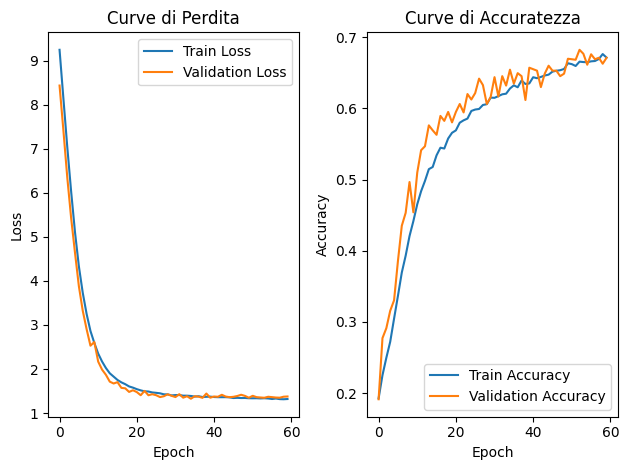

In [17]:
# Plot delle curve di perdita
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curve di Perdita')
plt.legend()

# Plot delle curve di accuratezza
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Curve di Accuratezza')
plt.legend()

plt.tight_layout()
plt.show()

23/23 [==============================] - 1s 33ms/step


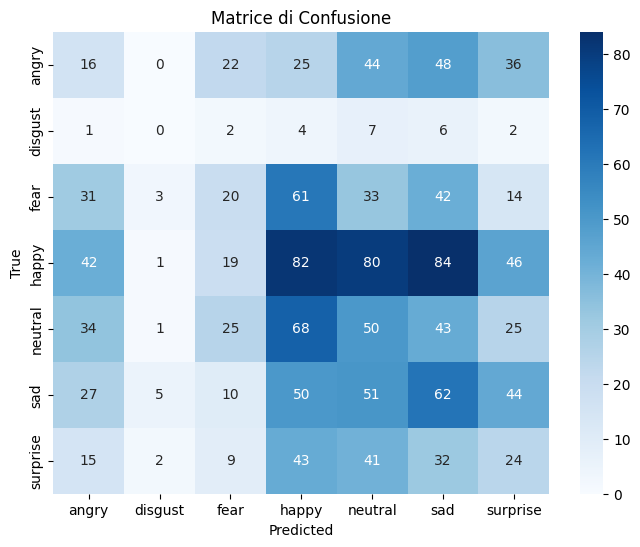

              precision    recall  f1-score   support

       angry       0.10      0.08      0.09       191
     disgust       0.00      0.00      0.00        22
        fear       0.19      0.10      0.13       204
       happy       0.25      0.23      0.24       354
     neutral       0.16      0.20      0.18       246
         sad       0.20      0.25      0.22       249
    surprise       0.13      0.14      0.13       166

    accuracy                           0.18      1432
   macro avg       0.14      0.14      0.14      1432
weighted avg       0.18      0.18      0.17      1432



In [18]:
# Funzione per ottenere le previsioni del modello
def get_predictions(model, generator):
    predictions = model.predict(generator)
    return np.argmax(predictions, axis=1)

# Ottenere le previsioni e le etichette reali per il set di test
y_pred = get_predictions(best_model, test_generator)
y_true = test_generator.classes

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matrice di Confusione')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualizza il report di classificazione
print(classification_report(y_true, y_pred, target_names=classes))

## Test modello

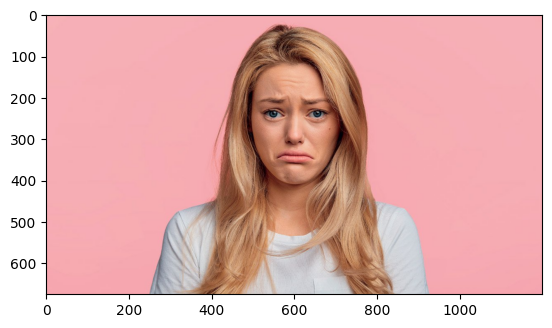

In [ ]:
# Leggi l'immagine di test scaricata in OpenCV
test_img = cv2.imread('sad.jpg')
# Fai un backup dell'immagine di input prima della rilevazione del viso
img_bcp = test_img.copy()

# Mostra l'immagine in OpenCV
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

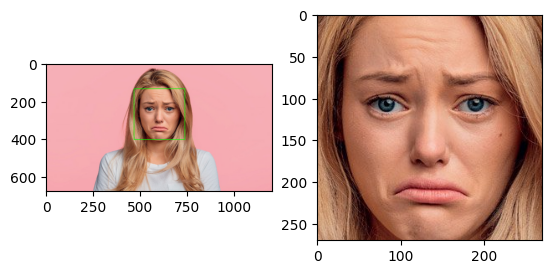

In [ ]:
# Definisci il classificatore di cascata di Haar per la rilevazione del viso
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Converti l'immagine in scala di grigi in OpenCV
gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Rileva il viso usando il classificatore di cascata di Haar
faces_coordinates = face_classifier.detectMultiScale(gray_img)

# Ordina le facce in base all'area (larghezza * altezza)
sorted_faces = sorted(faces_coordinates, key=lambda x: x[2] * x[3], reverse=True)

# Se ci sono facce rilevate
if len(sorted_faces) > 0:
    # Seleziona solo la faccia più grande
    x, y, w, h = sorted_faces[0]

    # Disegna un rettangolo intorno alla faccia più grande
    cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Ritaglia la faccia più grande dall'immagine
    cropped_face = img_bcp[y:y+h, x:x+w]

# Mostra l'immagine originale
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

# Mostra l'immagine ritagliata dopo aver eseguito la rilevazione del viso
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))

In [ ]:
# Creazione del dizionario delle classi
class_dictionary = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

final_image = cv2.resize(cropped_face, (224,224))
final_image = np.expand_dims(final_image, axis=0) ## Necessario per la quarta dimensione
final_image = final_image/255.0 ## Normalizzazione

# Carica il modello
new_model = tf.keras.models.load_model('best_model.h5')
prediction = new_model.predict(final_image)
class_dictionary[np.argmax(prediction)]

1/1 [==============================] - 1s 733ms/step


'sad'